## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
os.makedirs("../figures", exist_ok=True)
sys.path.append("..")
from src import *

## Load dataset

In [2]:
X_train = np.load('../data/processed/X_train.npy')
X_val   = np.load('../data/processed/X_val.npy')
y_train = np.load('../data/processed/y_train.npy')
y_val   = np.load('../data/processed/y_val.npy')
all_feature_names = np.load('../data/processed/all_feature_names.npy', allow_pickle=True)

## Model: Logistic Regression

**Note:** In this model, I choose
- Learning rate (alpha) = 0.05
- Number of iterations = 5000
- Lambda regularization = 0.001
- Decision boundary (threshold) = 0.38

### 1. Checking size of dataset

In [3]:
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val:   {X_val.shape}, {y_val.shape}")
print(f"Number of features: {len(all_feature_names)}")

Train: (8102, 34), (8102,)
Val:   (2025, 34), (2025,)
Number of features: 34


### 2. Train Logistic Regression

In [4]:
model = LogisticRegression(learning_rate=0.05, num_iterations=5000, lambda_reg=0.001)
model.fit(X_train, y_train)

### 3. Predict in validation set and rate

In [5]:
y_proba = model.predict_proba(X_val)
y_pred  = model.predict(X_val)


acc = accuracy(y_val, y_pred)
prec = precision(y_val, y_pred)
rec = recall(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
auc = roc_auc(y_val, y_proba)

print(f"\nResult of validation set")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")
print(f"AUC       : {auc:.4f} ")


Result of validation set
Accuracy  : 0.9086
Precision : 0.7383
Recall    : 0.6728
F1-score  : 0.7040
AUC       : 0.9256 


### 4. ROC Curve

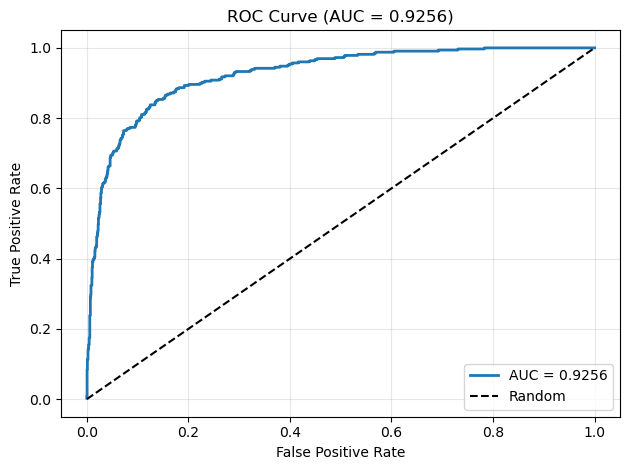

In [6]:
sort_idx = np.argsort(-y_proba)
y_true = y_val[sort_idx]
tpr = np.cumsum(y_true) / np.sum(y_true)
fpr = np.cumsum(1 - y_true) / np.sum(1 - y_true)

plot_roc(fpr, tpr, auc, title=f'ROC Curve (AUC = {auc:.4f})',save_path='../figures/roc_curve.png')
plt.show()

### 5. Confusion Matrix

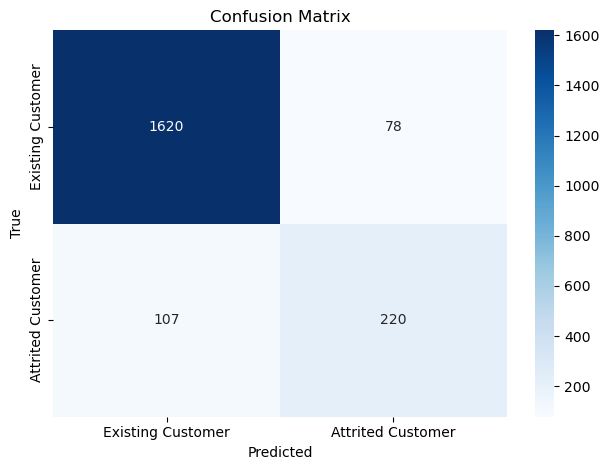

In [7]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred)
plot_confusion_matrix(cm, labels=['Existing Customer', 'Attrited Customer'],
                      title='Confusion Matrix', save_path='../figures/confusion_matrix.png')
plt.show()

### 6. Feature Importance

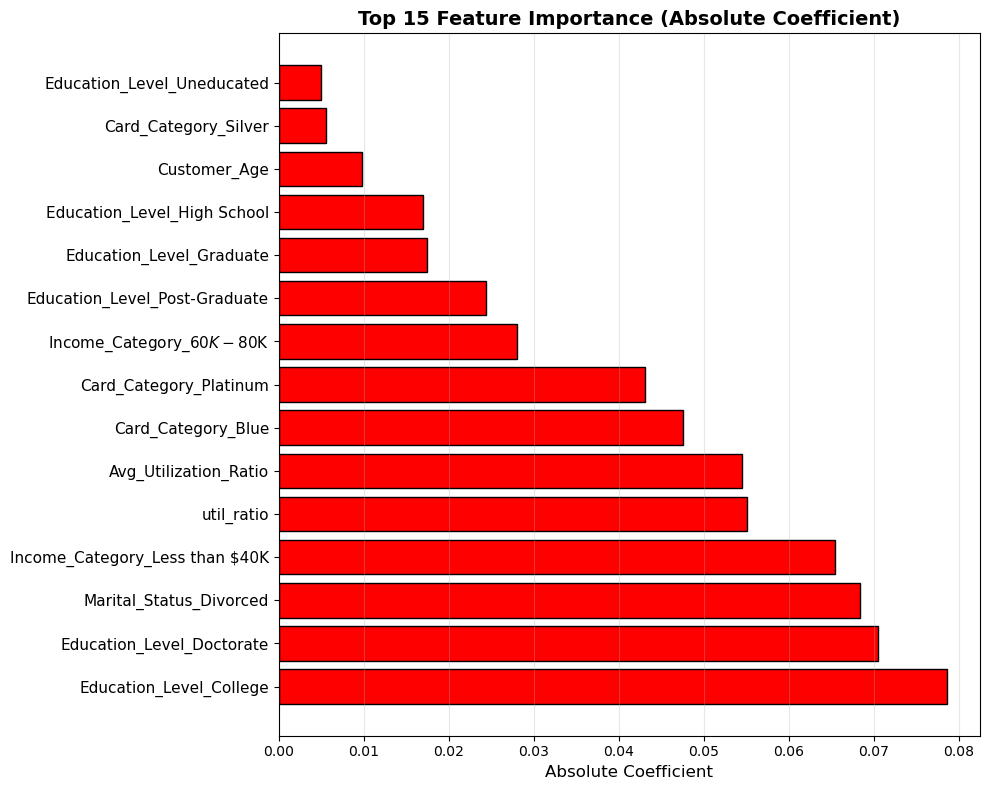

In [8]:
coefs = model.weights
plot_feature_importance(coefs, all_feature_names, n_top=15,
                        title='Top 15 Feature Importance (Absolute Coefficient)', save_path='../figures/feature_importance.png')
plt.show()


## Business Questions Answers

### 1. Top 5 factors predicting churn strongest (by coefficient):

In [9]:
top5_idx = np.argsort(-np.abs(coefs))[:5]
for i, idx in enumerate(top5_idx, 1):
    print(f" {i}. {all_feature_names[idx]:35} (coef = {coefs[idx]:.4f})")

 1. Total_Trans_Ct                      (coef = -1.8926)
 2. avg_trans_amt                       (coef = 1.5246)
 3. Total_Ct_Chng_Q4_Q1                 (coef = -0.7580)
 4. Total_Relationship_Count            (coef = -0.6882)
 5. Total_Revolving_Bal                 (coef = -0.6671)


### 2. Characteristics of customers most likely to churn?
   - Total_Revolving_Bal = 0 (not using revolving credit limit)
   - Months_Inactive_12_mon ≥ 3 (inactive for ≥ 3 months)
   - Contacts_Count_12_mon ≥ 3 (frequent contacts from staff => potential issues)
   - Low Total_Trans_Ct + low avg_trans_amt
   - Education Level: Graduate & Doctorate have higher churn rate

### 3. Recommendations to retain customers (business actions):   
   - Send offers to increase limit + cashback for customers with Total_Revolving_Bal = 0
   - Reactivation program (gift points, vouchers) for customers inactive ≥ 2 months
   - Proactive contact & special care for customers with Contacts_Count ≥ 2 in a month
   - Birthday gifts / personalized offers for Graduate & Doctorate group
   - Encourage more transactions through cashback for customers with low avg_trans_amt